In [1]:
import os
import sys
import numpy as np
import collections
import argparse
from numpy import ones, tile
from mcbits import coders, util
from models.toy_hmm_model import HMMToyModel
import random

exp_name = "cleanliness_convergence_plots_toy_hmm"
dir_name = os.path.join('./save', exp_name)
if not os.path.exists(dir_name):
    os.makedirs(dir_name)

# Arguments

In [2]:
# toy experiment parameters, use smaller values to get results faster
alphabet_size = 16
latent_alphabet_size = 32
length = 10
message_length = 2000

# rANS stack parameters
mprec = 16
bprec = 32
lprec = 32

# increase the num of particles from [1, 2, ..., 2^log_max]
log_max = 8

# Toy HMM Model

In [3]:
np.random.seed(1234)

# model
model = HMMToyModel(latent_alphabet_size, alphabet_size, length)

# get message
message = model.sample_message(message_length)

# NOTE: we use the average negative logprob as the ENTROPY
ENTROPY = - model.log_prob(message) / message_length

# uniform distribution as posterior
prop_counts = lambda x, state=None: np.ones((model.lals,)) / model.lals

def get_trans_count_stat_func(z_prev, state=None):
    if z_prev is None:
        return util.Categorical(mprec, model.prior_probs, use_make_sum_to_M=True)
    else:
        return util.Categorical(mprec, model.transition_probs[z_prev], use_make_sum_to_M=True)

In [4]:
# base coder arguments
coder_class = coders.SMCBitsBackCoder
coder_kwargs = {
    "init_state": lambda : None,
    "update_state": lambda cur_state=None, x_t=None, z_t=None: None,
    "get_prop_count_stat_func": lambda x_t, cur_state=None: util.Categorical(mprec, prop_counts(x_t, cur_state), use_make_sum_to_M=True),
    "get_cond_count_stat_func": lambda z_t, cur_state=None: util.Categorical(mprec, model.emission_probs[z_t], use_make_sum_to_M=True),
    "get_trans_count_stat_func": get_trans_count_stat_func,
    "default_symlen": length,
    "mprec": mprec, "lprec": lprec, "bprec": bprec,
    "multidim": False, "use_statfunc": False,
}

# BB-ELBO Coder

In [5]:
# NOTE: BB-SIS equals to BB-SMC without resampling and # particles = 1

coder_kwargs["num_particles"] = 1
coder_kwargs["resample"] = False
coder_kwargs["adaptive"] = False

# NOTE: we use the average negative sis approximation of the logprob as the ideal length
ideal_bits_bitsback = -model.log_prob(message, method="smc", N=1, 
                                          prop_counts=prop_counts, resampling=False, adaptive=False)/message_length

coder = coder_class(**coder_kwargs)
coder.encode(message)
true_bits_bitsback = coder.bit_length / message_length
true_net_bits_bitsback = coder.net_bit_length / message_length


print(f"BB-ELBO")
print(f"\tentropy : {ENTROPY}")
print(f"\tideal bit length : {ideal_bits_bitsback}")
print(f"\ttrue bit length : {true_bits_bitsback}")
print(f"\ttrue net bit length : {true_net_bits_bitsback}")

BB-ELBO
	entropy : 39.97538123749399
	ideal bit length : 46.10800913833613
	true bit length : 48.294297271196676
	true net bit length : 48.24629727119668


## Save

In [6]:
np.save(os.path.join(dir_name, "entropy"), np.array([ENTROPY]))
np.save(os.path.join(dir_name, "ideal_bits_bitsback"), np.array([ideal_bits_bitsback]))
np.save(os.path.join(dir_name, "true_bits_bitsback"), np.array([true_bits_bitsback]))
np.save(os.path.join(dir_name, "true_net_bits_bitsback"), np.array([true_net_bits_bitsback]))

# BB-SMC Coder

## Compute compression rate vs # particles

In [7]:
num_particles_array = list(2 ** np.arange(log_max + 1))
print(num_particles_array)

[1, 2, 4, 8, 16, 32, 64, 128, 256]


In [8]:
ideal_bits_smc_bitsback_array = [] 
true_bits_smc_bitsback_array = []
true_net_bits_smc_bitsback_array = []

for num_particles in num_particles_array:
    coder_kwargs["num_particles"] = num_particles
    
    coder_kwargs["resample"] = True
    coder_kwargs["adaptive"] = False
    
    # NOTE: we use the average negative smc approximation of the logprob as the ideal length
    ideal_bits_smc_bitsback = -model.log_prob(message, method="smc", N=num_particles, 
                                              prop_counts=prop_counts, resampling=True, adaptive=False)/message_length

    
    coder = coder_class(**coder_kwargs)
    coder.encode(message)
    true_bits_smc_bitsback = coder.bit_length / message_length
    true_net_bits_smc_bitsback = coder.net_bit_length / message_length
    
    
    print(f"SMC # Particles={num_particles}")
    print(f"\tentropy : {ENTROPY}")
    print(f"\tideal bit length : {ideal_bits_smc_bitsback}")
    print(f"\ttrue bit length : {true_bits_smc_bitsback}")
    print(f"\ttrue net bit length : {true_net_bits_smc_bitsback}")

    ideal_bits_smc_bitsback_array.append(ideal_bits_smc_bitsback)
    true_bits_smc_bitsback_array.append(true_bits_smc_bitsback)
    true_net_bits_smc_bitsback_array.append(true_net_bits_smc_bitsback)

# for consistency
ideal_bits_smc_bitsback_array[0] = ideal_bits_bitsback
true_bits_smc_bitsback_array[0] = true_bits_bitsback
true_net_bits_smc_bitsback_array[0] = true_net_bits_bitsback

SMC # Particles=1
	entropy : 39.97538123749399
	ideal bit length : 46.07653326274759
	true bit length : 48.365250093552234
	true net bit length : 48.31725009355223
SMC # Particles=2
	entropy : 39.97538123749399
	ideal bit length : 42.88694142008018
	true bit length : 42.92209691444339
	true net bit length : 42.84209691444338
SMC # Particles=4
	entropy : 39.97538123749399
	ideal bit length : 41.29179890985434
	true bit length : 41.45187192166283
	true net bit length : 41.29187192166283
SMC # Particles=16
	entropy : 39.97538123749399
	ideal bit length : 40.29913436683707
	true bit length : 40.97732685157131
	true net bit length : 40.305326851571316
SMC # Particles=32
	entropy : 39.97538123749399
	ideal bit length : 40.10792989629929
	true bit length : 41.66029471928586
	true net bit length : 40.17229471928586
SMC # Particles=64
	entropy : 39.97538123749399
	ideal bit length : 40.045503189227404
	true bit length : 43.34835620189788
	true net bit length : 40.13235620189788
SMC # Particles=

## Save

In [9]:
np.save(os.path.join(dir_name, "ideal_bits_smc_bitsback_array"), np.array(ideal_bits_smc_bitsback_array))
np.save(os.path.join(dir_name, "true_bits_smc_bitsback_array"), np.array(true_bits_smc_bitsback_array))
np.save(os.path.join(dir_name, "true_net_bits_smc_bitsback_array"), np.array(true_net_bits_smc_bitsback_array))

# BB-SIS Coder

## Compute compression rate vs # particles

In [10]:
ideal_bits_sis_bitsback_array = [] 
true_bits_sis_bitsback_array = []
true_net_bits_sis_bitsback_array = []

for num_particles in num_particles_array:
    coder_kwargs["num_particles"] = num_particles
    
    # NOTE: BB-SIS equals to BB-SMC without resampling 
    coder_kwargs["resample"] = False
    coder_kwargs["adaptive"] = False
    
    # NOTE: we use the average negative sis approximation of the logprob as the ideal length
    ideal_bits_sis_bitsback = -model.log_prob(message, method="smc", N=num_particles, 
                                              prop_counts=prop_counts, resampling=False, adaptive=False)/message_length

    coder = coder_class(**coder_kwargs)
    coder.encode(message)
    true_bits_sis_bitsback = coder.bit_length / message_length
    true_net_bits_sis_bitsback = coder.net_bit_length / message_length
    
    
    print(f"SIS # Particles={num_particles}")
    print(f"\tentropy : {ENTROPY}")
    print(f"\tideal bit length : {ideal_bits_sis_bitsback}")
    print(f"\ttrue bit length : {true_bits_sis_bitsback}")
    print(f"\ttrue net bit length : {true_net_bits_sis_bitsback}")

    ideal_bits_sis_bitsback_array.append(ideal_bits_sis_bitsback)
    true_bits_sis_bitsback_array.append(true_bits_sis_bitsback)
    true_net_bits_sis_bitsback_array.append(true_net_bits_sis_bitsback)

# for consistency
ideal_bits_sis_bitsback_array[0] = ideal_bits_bitsback
true_bits_sis_bitsback_array[0] = true_bits_bitsback
true_net_bits_sis_bitsback_array[0] = true_net_bits_bitsback

SIS # Particles=1
	entropy : 39.97538123749399
	ideal bit length : 45.963768441460424
	true bit length : 48.360511990407346
	true net bit length : 48.312511990407344
SIS # Particles=2
	entropy : 39.97538123749399
	ideal bit length : 44.157449196283444
	true bit length : 44.42736004138657
	true net bit length : 44.34736004138657
SIS # Particles=4
	entropy : 39.97538123749399
	ideal bit length : 42.81182992690225
	true bit length : 42.97911501002739
	true net bit length : 42.85111501002739
SIS # Particles=8
	entropy : 39.97538123749399
	ideal bit length : 41.95497886509199
	true bit length : 42.17508354819177
	true net bit length : 41.951083548191775
SIS # Particles=16
	entropy : 39.97538123749399
	ideal bit length : 41.31891356998525
	true bit length : 41.86306352512496
	true net bit length : 41.431063525124955
SIS # Particles=32
	entropy : 39.97538123749399
	ideal bit length : 40.82851328639524
	true bit length : 41.86774222695562
	true net bit length : 41.03574222695562
SIS # Particle

## Save

In [11]:
np.save(os.path.join(dir_name, "ideal_bits_sis_bitsback_array"), np.array(ideal_bits_sis_bitsback_array))
np.save(os.path.join(dir_name, "true_bits_sis_bitsback_array"), np.array(true_bits_sis_bitsback_array))
np.save(os.path.join(dir_name, "true_net_bits_sis_bitsback_array"), np.array(true_net_bits_sis_bitsback_array))

# Load

In [12]:
# BB-ELBO
ENTROPY = np.load(os.path.join(dir_name, "entropy.npy"))[0]
ideal_bits_bitsback = np.load(os.path.join(dir_name, "ideal_bits_bitsback.npy"))[0]
true_bits_bitsback = np.load(os.path.join(dir_name, "true_bits_bitsback.npy"))[0]
true_net_bits_bitsback = np.load(os.path.join(dir_name, "true_net_bits_bitsback.npy"))[0]

# BB-SIS
ideal_bits_sis_bitsback_array = np.load(os.path.join(dir_name, "ideal_bits_sis_bitsback_array.npy"))
true_bits_sis_bitsback_array = np.load(os.path.join(dir_name, "true_bits_sis_bitsback_array.npy"))
true_net_bits_sis_bitsback_array = np.load(os.path.join(dir_name, "true_net_bits_sis_bitsback_array.npy"))

# BB-SMC
ideal_bits_smc_bitsback_array = np.load(os.path.join(dir_name, "ideal_bits_smc_bitsback_array.npy"))
true_bits_smc_bitsback_array = np.load(os.path.join(dir_name, "true_bits_smc_bitsback_array.npy"))
true_net_bits_smc_bitsback_array = np.load(os.path.join(dir_name, "true_net_bits_smc_bitsback_array.npy"))

# Plot

In [13]:
from matplotlib import rc
from matplotlib import pyplot as plt

# rc('text', usetex=True)
# rc('font',**{'size':10, "family" : "serif", "serif" : "Times"})
# rc('text.latex', preamble=r'\usepackage{amsfonts}')
# rc('text.latex', unicode=True)

In [14]:
plot_max = 9

plot_marker_style = {'marker': 'o', 'markersize': 3}
scatter_marker_style = {'marker': 'x', 's': 60}

## Cleanliness Plot

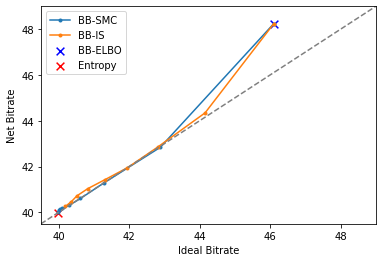

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1)
bb_smc, = ax.plot(ideal_bits_smc_bitsback_array[:plot_max], true_net_bits_smc_bitsback_array[:plot_max], label="BB-SMC", **plot_marker_style)
bb_sis, = ax.plot(ideal_bits_sis_bitsback_array[:plot_max], true_net_bits_sis_bitsback_array[:plot_max], label="BB-IS", **plot_marker_style)
bb_elbo = ax.scatter([ideal_bits_bitsback], [true_net_bits_bitsback], label="BB-ELBO", c='b', **scatter_marker_style)
bb_ideal = ax.scatter([ENTROPY], [ENTROPY], label="Entropy", c='r', **scatter_marker_style)


start = 39.5
end = 49.0
ax.set_xlim([start, end])
ax.set_ylim([start, end])
ax.plot([start, end], [start, end], ls='--', c='gray')
ax.legend()
ax.set_xlabel("Ideal Bitrate")
ax.set_ylabel("Net Bitrate")

plt.show()

## Convergence Plot

/scratch/ssd002/home/ryoungj/conda_envs/mcbits_test/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


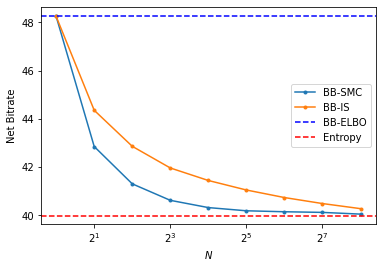

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1)
bb_smc, = ax.plot(num_particles_array[:plot_max], true_net_bits_smc_bitsback_array[:plot_max], label="BB-SMC", **plot_marker_style)
bb_sis, = ax.plot(num_particles_array[:plot_max], true_net_bits_sis_bitsback_array[:plot_max], label="BB-IS", **plot_marker_style)
bb_elbo = ax.axhline(true_net_bits_bitsback, label=r'BB-ELBO', c='b', ls='--')
bb_ideal = ax.axhline(ENTROPY, label=r'Entropy', c='r', ls='--')

ax.legend(frameon=True)
ax.set_xlabel(r'$N$')
ax.set_ylabel('Net Bitrate')
ax.set_xscale('log', basex=2)
plt.legend()

plt.show()